[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


2024-01-17, AMZN Close: 151.71, RSI: 55.15, RSI-MA: 59.08, Position: 0.00, PNL: 0.00%
2024-01-17, SNOW Close: 188.12, RSI: 45.42, RSI-MA: 54.22, Position: 0.00, PNL: 0.00%
2024-01-17, MSFT Close: 389.47, RSI: 69.65, RSI-MA: 58.31, Position: 0.00, PNL: 0.00%
2024-01-17, AAPL Close: 182.68, RSI: 39.03, RSI-MA: 45.95, Position: 0.00, PNL: 0.00%
2024-01-17, GOOG Close: 142.89, RSI: 63.12, RSI-MA: 66.13, Position: 0.00, PNL: 0.00%
2024-01-17, NVDA Close: 56.05, RSI: 76.90, RSI-MA: 68.07, Position: 0.00, PNL: 0.00%
2024-01-17, META Close: 368.37, RSI: 68.21, RSI-MA: 71.37, Position: 0.00, PNL: 0.00%
2024-01-18, AMZN Close: 153.50, RSI: 58.61, RSI-MA: 59.04, Position: 0.00, PNL: 0.00%
2024-01-18, SNOW Close: 186.61, RSI: 43.54, RSI-MA: 53.46, Position: 0.00, PNL: 0.00%
2024-01-18, MSFT Close: 393.87, RSI: 73.15, RSI-MA: 59.37, Position: 0.00, PNL: 0.00%
2024-01-18, AAPL Close: 188.63, RSI: 52.91, RSI-MA: 46.45, Position: 0.00, PNL: 0.00%
2024-01-18, GOOG Close: 144.99, RSI: 67.22, RSI-MA: 66.

<IPython.core.display.Javascript object>

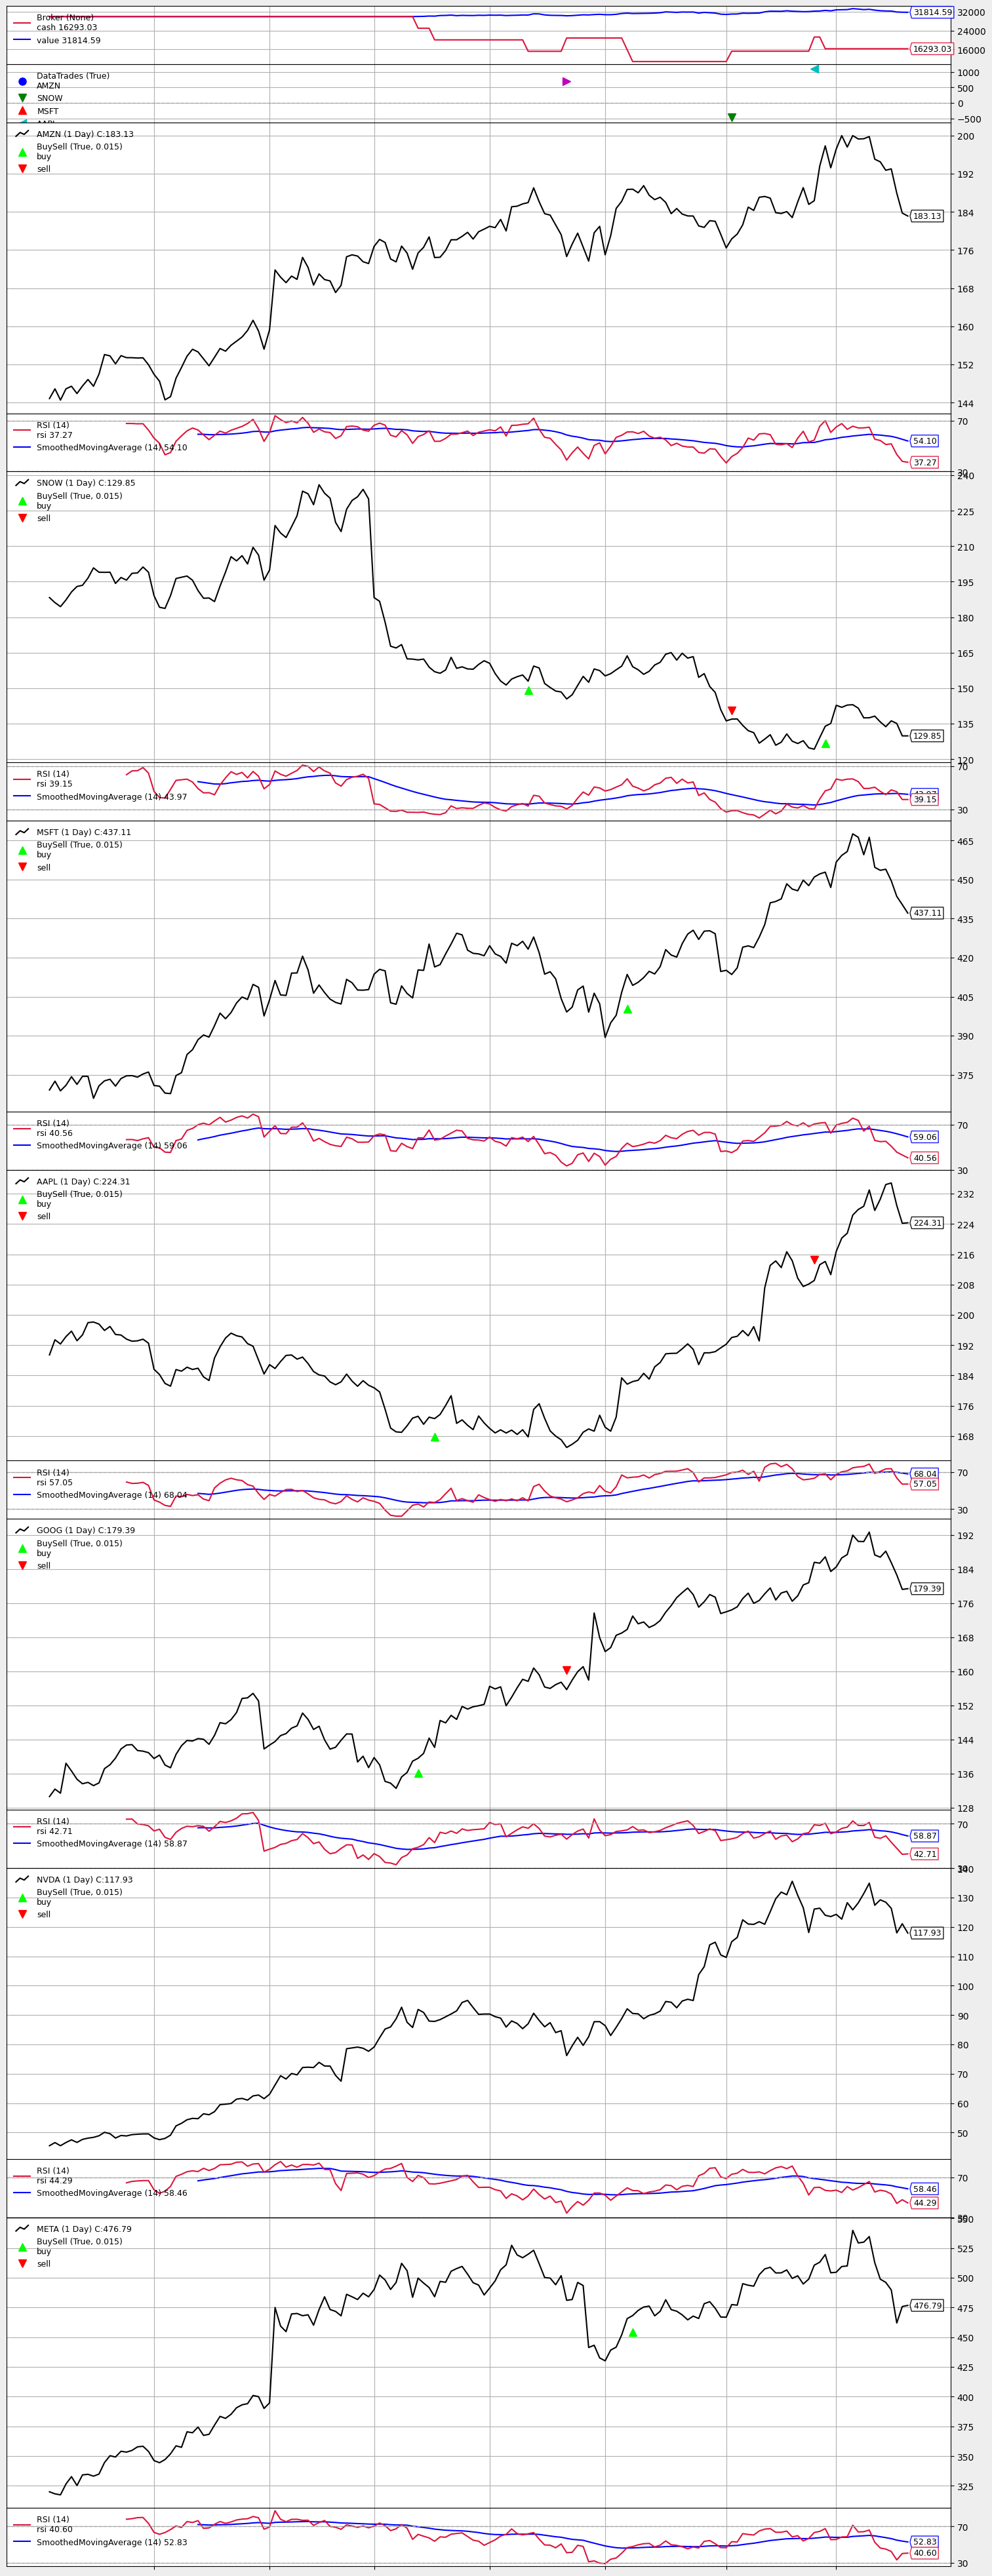

In [8]:
from api.services.backtesting_service import TestStrategy, rsi_warmup_in_days

import datetime  # For datetime objects
import backtrader as bt
import backtrader.analyzers as btanalyzers
import yfinance as yf

optimise = False
initial_cash = 30000
number_of_days_to_simulate = 200
end_date=datetime.datetime.today().date()
start_date = end_date - datetime.timedelta(number_of_days_to_simulate + rsi_warmup_in_days)
#tickers = ['SNOW']
tickers = [ 'AMZN', 'SNOW', 'MSFT', 'AAPL', 'GOOG', 'NVDA', 'META']
#tickers = [ 'AMZN', 'SNOW', 'MSFT', 'AAPL', 'GOOG', 'NVDA', 'META', 'JNJ', 'JPM', 'PFE', 'PG', 'UNH', 'V']

def add_stats(rsi_lower, rsi_upper, loss_pct,final_value):
    stats.append({'rsi_lower': rsi_lower, 'rsi_upper': rsi_upper, 'loss_pct': loss_pct,'final_value': final_value}) 

def strategy_completed_callback(strategy):
    final_value = strategy.broker.get_value()
    print("strategy_completed_callback stats: " + 
        f'lower_rsi: {strategy.params.lower_rsi}, ' +
        f'upper_rsi: {strategy.params.upper_rsi}, ' +
        f'loss_pct: {strategy.params.loss_pct_threshold}, ' +
        f'final Portfolio Value: {final_value:.0f}'
    )
    stats.append({'rsi_lower': strategy.params.lower_rsi, 
        'rsi_upper': strategy.params.upper_rsi, 
        'loss_pct': strategy.params.loss_pct_threshold,
        'final_value': round(strategy.broker.getvalue())}) 

stats = []

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(optreturn=False)

    if not optimise:
        # Add a strategy
        cerebro.addstrategy(TestStrategy,
                            printlog=True,
                            upper_rsi=60,
                            lower_rsi=50,
                            loss_pct_threshold = 9,
                            fixed_investment_amount=5000)
    else:
        strats = cerebro.optstrategy(
            TestStrategy,
            upper_rsi=range(55, 70, 5),
            lower_rsi=range(30, 55, 5),
            loss_pct_threshold = 9,
            fixed_investment_amount=5000,
            custom_callback=strategy_completed_callback,
            )
        cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

    # Add the Data Feed to Cerebro
    for ticker in tickers:
        data = bt.feeds.PandasData(dataname=yf.download(ticker, start_date, end_date))
        cerebro.adddata(data=data, name=ticker)

    # Set our desired cash start
    cerebro.broker.setcash(initial_cash)

    # Print out the starting conditions
    start_portfolio_value = cerebro.broker.getvalue()

    # Run over everything
    opt_runs = cerebro.run(maxcpus=1)
   
    if optimise: 
        print('Optimised runs by Final Value:')
        sorted_results = sorted(stats, key=lambda x: x['final_value'], reverse=True)
        for result in sorted_results[:5]:
            print(result)
    else:
        # Print out the final result
        print(f'Portfolio Value Starting: {start_portfolio_value:.0f}, End: {cerebro.broker.getvalue():.0f}')
        print(f'Plotting graphs ...')
        # Plot the result
        %matplotlib inline
        import matplotlib.pyplot as plt
        from pylab import rcParams #Creates parameters for our plot
        rcParams['figure.figsize'] = 16, 6 * len(tickers) #size
        rcParams['figure.facecolor'] = '#eeeeee' #Color scheme
        plt.plot() #The Plot Code
        plt.close()
        cerebro.plot(iplot=True, volume=False)